In [2]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Reshape
from tensorflow.keras import Sequential

DIR = "../data/Raw/logRaws/"

NUM_SAMPLES = 2662
NUM_FEATURES = 6
NUM_FRAMES = 1000

file_names = os.listdir(DIR)
input_array = np.empty((NUM_SAMPLES, NUM_FRAMES, NUM_FEATURES))

# prepare data
def read_files(DIR):
    all_files = os.listdir(DIR)

    input_data = np.empty((0, 6), float)

    for file in all_files:
        file_path = os.path.join(DIR, file)
        df = pd.read_csv(file_path, usecols=[1, 19, 20, 21, 25, 26, 27], header=None)
        if df.shape[0] < 999:
            continue

        df.columns = ['frame', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
        df_input = df[['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']]
        df_input = df_input.astype('float32')

        input_data = np.append(input_data, df_input, axis=0)
    input_data = input_data.reshape(NUM_SAMPLES, NUM_FRAMES, NUM_FEATURES)

    # normalize
    # accel: [-16, 16] -> [-1, 1]
    # gyro: [-2000, 2000] -> [-1, 1]
    input_data[:, :, :3] = input_data[:, :, :3] / 16
    input_data[:, :, 3:] = input_data[:, :, 3:] / 2000

    return input_data

input_data = read_files(DIR)

print(input_data.shape)


2023-12-14 00:31:36.816606: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-14 00:31:36.828081: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 00:31:36.956044: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 00:31:36.958066: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 00:31:38.557555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

(2662, 1000, 6)


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, Layer

class CustomPadding(Layer):
    def __init__(self, padding_size, **kwargs):
        super(CustomPadding, self).__init__(**kwargs)
        self.padding_size = padding_size

    def call(self, inputs):
        initial_values = inputs[:, 0:1, :, :]
        final_values = inputs[:, -1:, :, :]

        initial_padding = tf.tile(
            initial_values,
            [1, self.padding_size, 1, 1]
        )
        final_padding = tf.tile(
            final_values,
            [1, self.padding_size, 1, 1]
        )

        return tf.concat([initial_padding, inputs, final_padding], axis=1)

    def compute_output_shape(self, input_shape):
        return (
            input_shape[0],
            input_shape[1] + 2 * self.padding_size,
            input_shape[2],
            input_shape[3]
        )

class CustomCropping(Layer):
    def __init__(self, cropping_size, **kwargs):
        super(CustomCropping, self).__init__(**kwargs)
        self.cropping_size = cropping_size

    def call(self, inputs):
        return inputs[:, self.cropping_size:-self.cropping_size, :, :]

    def compute_output_shape(self, input_shape):
        return (
            input_shape[0],
            input_shape[1] - 2 * self.cropping_size,
            input_shape[2],
            input_shape[3]
        )

    def compute_output_shape(self, input_shape):
        return (
            input_shape[0],
            input_shape[1] - 2 * self.cropping_size,
            input_shape[2],
            input_shape[3]
        )

# Define a CNN-based autoencoder
def create_cnn_autoencoder():
    autoencoder = Sequential([
        Input(shape=(1000, 6)),
        Reshape((1000, 6, 1)),
        CustomPadding(padding_size=10),

        # Encoder
        Conv2D(8, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same'),

        # Decoder
        UpSampling2D((2, 2)),
        Conv2D(8, (3, 3), activation='relu', padding='same'),

        Conv2D(1, (3, 3), activation='tanh', padding='same'),
        CustomCropping(cropping_size=10),
        Reshape((1000, 6))
    ])

    return autoencoder



In [4]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test = train_test_split(input_data, test_size=0.2, random_state=42)

# Create and compile the CNN autoencoder
autoencoder = create_cnn_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Train the model
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1000, 6, 1)        0         
                                                                 
 custom_padding (CustomPadd  (None, 1020, 6, 1)        0         
 ing)                                                            
                                                                 
 conv2d (Conv2D)             (None, 1020, 6, 8)        80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 510, 3, 8)         0         
 D)                                                              
                                                                 
 up_sampling2d (UpSampling2  (None, 1020, 6, 8)        0         
 D)                                                              
                                                        

17/17 [==============================] - 0s 11ms/step


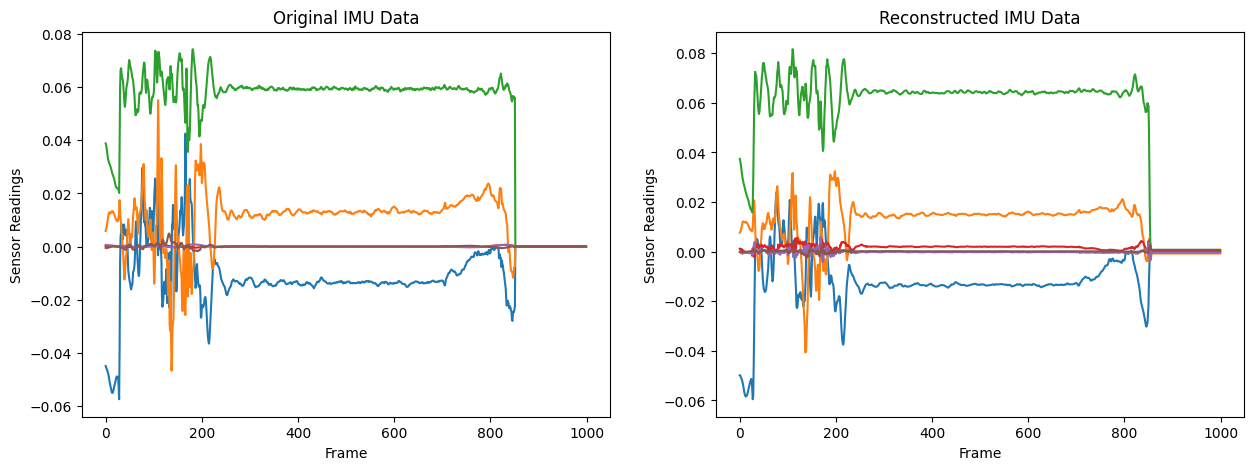

In [5]:
import matplotlib.pyplot as plt

filtered_data = autoencoder.predict(X_test)

INDEX = 48

# Plotting
plt.figure(figsize=(15, 5))

# Original Data
plt.subplot(1, 2, 1)
plt.plot(X_test[INDEX])
plt.title("Original IMU Data")
plt.xlabel("Frame")
plt.ylabel("Sensor Readings")

# Reconstructed Data
plt.subplot(1, 2, 2)
plt.plot(filtered_data[INDEX])
plt.title("Reconstructed IMU Data")
plt.xlabel("Frame")
plt.ylabel("Sensor Readings")

plt.show()


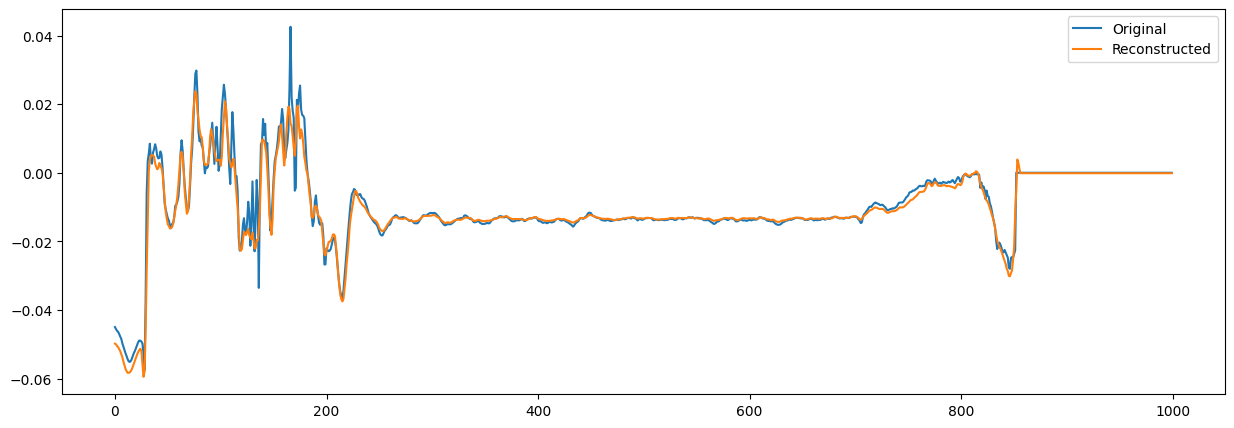

In [6]:
# plot one axis of one sensor: both original and reconstructed
plt.figure(figsize=(15, 5))
plt.plot(X_test[INDEX, :, 0], label='Original')
plt.plot(filtered_data[INDEX, :, 0], label='Reconstructed')
plt.legend()
plt.show()

In [7]:
import tensorflow as tf

# save model
export_path = "./autoencoder/multi_channel"
tf.saved_model.save(autoencoder, export_path)

INFO:tensorflow:Assets written to: ./autoencoder/multi_channel/assets


INFO:tensorflow:Assets written to: ./autoencoder/multi_channel/assets
